# 1. 图像分割和实例分割

# 2. Pascal VOC2012 语义分割数据集

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from d2l import torch as d2l

In [2]:
from utils.read_utils import read_voc_images

voc_dir = '../data/VOCdevkit/VOC2012'
train_features, train_labels = read_voc_images(voc_dir, True)

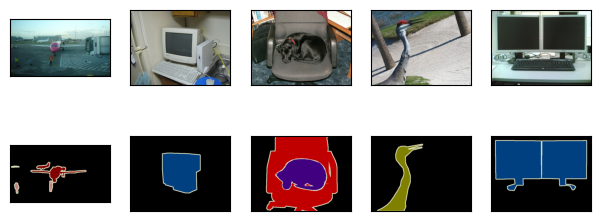

In [3]:
n = 5
imgs = train_features[0:n] + train_labels[0:n]

# 图像一般存储为 (通道数, 高度, 宽度) 的格式，
# 为了正确显示图像，需要将其转换为 (高度, 宽度, 通道数) 的格式
imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs, 2, n);

In [4]:
# 列举RGB颜色值和类名

VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

In [5]:
"""
RGB 颜色空间的每个通道有 256 个可能的取值（从 0 到 255）
因此，RGB 颜色组合总数为：256×256×256=16777216

R: 红色通道，取值范围为 0 到 255
G: 绿色通道，取值范围为 0 到 255
B: 蓝色通道，取值范围为 0 到 255

(R * 256 + G) * 256 + B 不会超过 256 × 256 × 256

为什么是这样的公式？

首先B做贡献 0-255
          =>目前可表示范围 0-255
          
接着G做贡献 1 * 256 + B(0-255) 、 2 * 256 + B(0-255)  ...    255 * 256 + B(0-255)
          =>目前可表示范围 0- (255 * 256 + 255)
                       =0- (256 * 256 -1)    
            
最后R做贡献 (1 * 256) * 256 + G(0-255) * 256 + B(0-255) ... (2 * 256) * 256 + G(0-255) * 256 + B(0-255)
          =>目前可表示范围 0- (255 * 256) * 256 + 255 * 256 + 255 
                       =0- (255 * 256 + 255) * 256 + 255
                       =0- (256 *256 -1) * 256 + 255
                       =0- (256 *256 *256) -256 +255
                       =0- (256 *256 *256) -1
"""

"""
返回值： 每个VOC_COLORMAP中每个RGB对应的类别

类别用数字表示
范围=length(VOC_COLORMAP)
"""
def voc_colormap2label():
    """构建从RGB到VOC类别索引的映射"""
    colormap2label = torch.zeros(256 ** 3, dtype=torch.long)
    for i, colormap in enumerate(VOC_COLORMAP):
        colormap2label[
            (colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i
    return colormap2label

"""
【计算图像的类别值】
每个图像的每个像素对应的分类索引，再计算出分类索引对应的类别值
"""
def voc_label_indices(colormap, colormap2label):
    """将VOC标签中的RGB值映射到它们的类别索引"""
    colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256
           + colormap[:, :, 2])
    return colormap2label[idx]

In [6]:
print(train_labels[0].permute(1, 2, 0).shape[0:2])

y = voc_label_indices(train_labels[0], voc_colormap2label())
y[105:115, 130:140], VOC_CLASSES[1]

torch.Size([281, 500])


(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]),
 'aeroplane')

In [7]:
y[105:115, 330:340], VOC_CLASSES[1]

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 'aeroplane')

## 2.1. 预处理数据

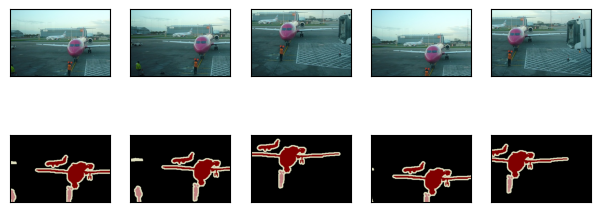

In [8]:
"""
【对输入的图像和标签进行随机裁剪】
    feature: 输入的特征图像（通常为RGB图像或特征图）
    label: 输入的标签图像（对应于分割任务中的标签）
    height : 裁剪后的目标图像高度
    width : 裁剪后的目标图像宽度
"""
def voc_rand_crop(feature, label, height, width):
    
    # 获取裁剪的随机参数：返回一个包含 (top, left, height, width) 的元组
    rect = torchvision.transforms.RandomCrop.get_params(feature, (height, width))
    # 使用裁剪参数裁剪特征图像
    feature = torchvision.transforms.functional.crop(feature, *rect)
    # 使用相同的裁剪参数裁剪标签图像
    label = torchvision.transforms.functional.crop(label, *rect)
    # 返回裁剪后的特征图像和标签图像
    return feature, label

imgs = []
for _ in range(n):
    imgs += voc_rand_crop(train_features[0], train_labels[0], 200, 300)

imgs = [img.permute(1, 2, 0) for img in imgs]
d2l.show_images(imgs[::2] + imgs[1::2], 2, n);

## 2.2. 自定义语义分割数据集类

In [9]:
"""
【加载并预处理 VOC 数据集中的图像和标签】
"""
class VOCSegDataset(torch.utils.data.Dataset):
    """一个用于加载VOC数据集的自定义数据集"""

    def __init__(self, is_train, crop_size, voc_dir):
        
        # 图像像素值标准化
        self.transform = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        # 裁剪尺寸，用于裁剪输入图像和标签图像
        self.crop_size = crop_size
        
        # 加载图像和标签
        features, labels = read_voc_images(voc_dir, is_train=is_train)
        
        # 过滤图像，并将像素值标准化
        self.features = [self.normalize_image(feature) for feature in self.filter(features)]
        
        # 过滤标签
        self.labels = self.filter(labels)
        self.colormap2label = voc_colormap2label()
        print('read ' + str(len(self.features)) + ' examples')

    """
    【图像像素值标准化】
    """
    def normalize_image(self, img):
        return self.transform(img.float() / 255)

    """
    【过滤掉尺寸小于裁剪大小的图像】
    """
    def filter(self, imgs):
        return [img for img in imgs if (
            img.shape[1] >= self.crop_size[0] and
            img.shape[2] >= self.crop_size[1])]

    """
    【根据索引获取图像和图像类别值】
    """
    def __getitem__(self, idx):
        feature, label = voc_rand_crop(self.features[idx], self.labels[idx],
                                       *self.crop_size)
        return (feature, voc_label_indices(label, self.colormap2label))

    """
    【总图像数】
    """
    def __len__(self):
        return len(self.features)

## 2.3. 读取数据集

In [10]:
# 定义目标裁剪尺寸
crop_size = (320, 480)

# 加载并预处理 VOC 数据集中的图像和标签
voc_train = VOCSegDataset(True, crop_size, voc_dir)
voc_test = VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [11]:
# 如果这个单元格运行卡住了，把num_workers这项参数去掉就可以了，不需要多线程读取。
batch_size = 64
train_iter = torch.utils.data.DataLoader(voc_train, batch_size, shuffle=True,
                                    drop_last=True)
for X, Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

torch.Size([64, 3, 320, 480])
torch.Size([64, 320, 480])


## 2.4. 整合所有组件

In [12]:
def load_data_voc(batch_size, crop_size):
    """加载VOC语义分割数据集"""
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        VOCSegDataset(True, crop_size, voc_dir), batch_size,
        shuffle=True, drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        VOCSegDataset(False, crop_size, voc_dir), batch_size,
        drop_last=True, num_workers=num_workers)
    return train_iter, test_iter